In [1]:
import pandas as pd



In [2]:
def mergeHeader(header, file):
    header = pd.read_csv(header)
    return pd.read_csv(file, sep = '|', names = header.columns)

In [3]:
#loading candidate names file
names = mergeHeader('data/names/cn_header_file.csv', 'data/names/cn.txt')


#loading democratic candidates from election year
candidates = names[(names['CAND_OFFICE'] == 'P') & (names['CAND_ELECTION_YR'] == 2016) & (names['CAND_PTY_AFFILIATION'].apply(lambda x: x in ['DEM', 'REP']))]

In [4]:
#committee names
cm = mergeHeader('data/cm/cm_header_file.csv', 'data/cm/cm.txt')


#committee candidate linkage  
ccl = mergeHeader('data/ccl/ccl_header_file.csv', 'data/ccl/ccl.txt')
#linking candidates subquery with committee linkage
convert = candidates.set_index('CAND_ID')[['CAND_NAME', 'CAND_PTY_AFFILIATION']].join(ccl.set_index('CAND_ID'), how='inner').reset_index()
#joining the linked with committee names
convert = convert.set_index('CMTE_ID').join(cm.set_index('CMTE_ID')['CMTE_NM'], how='left').reset_index()

In [5]:
#looking at the amount of values of sanders data
top = convert['CAND_NAME'].value_counts()[:6]
top


SANDERS, BERNARD                                   12
TRUMP, DONALD J. / MICHAEL R. PENCE                 3
POWELL, MICHEL ANISSA I                             3
BAILEY, GEORGE BRENT JR                             3
CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE     3
CRUZ, RAFAEL EDWARD "TED"                           3
Name: CAND_NAME, dtype: int64

In [6]:
cand = convert[convert['CAND_NAME'].apply(lambda x: x in top)]
allCommittees = cand['CMTE_ID'].unique().tolist()


#creating an object to query 
candCMT= {}
for c in cand['CMTE_ID'].unique():
    candCMT[c] = cand[cand['CMTE_ID'] == c]['CAND_NAME'].tolist()[0]

In [7]:
header = pd.read_csv('data/individual/indiv_header_file.csv')
contributionsRaw = pd.read_csv('data/individual/itcont.txt', sep='|', names=header.columns, nrows=5000)
contributionsRaw.columns

Index(['CMTE_ID', 'AMNDT_IND', 'RPT_TP', 'TRANSACTION_PGI', 'IMAGE_NUM',
       'TRANSACTION_TP', 'ENTITY_TP', 'NAME', 'CITY', 'STATE', 'ZIP_CODE',
       'EMPLOYER', 'OCCUPATION', 'TRANSACTION_DT', 'TRANSACTION_AMT',
       'OTHER_ID', 'TRAN_ID', 'FILE_NUM', 'MEMO_CD', 'MEMO_TEXT', 'SUB_ID'],
      dtype='object')

In [8]:
dtypes ={'TRANSACTION_DT': int, 'OCCUPATION': str}

In [9]:
iter_csv = pd.read_csv('data/individual/itcont.txt', sep='|', iterator=True, names=header.columns, chunksize=100000)
lst = []
i = 1
for chunk in iter_csv:
    if i % 100 == 0:
        print('chunk ' + str(i))
    i +=1
    lst += [chunk[chunk['CMTE_ID'].apply(lambda x: x in allCommittees)][['CMTE_ID', 'TRANSACTION_AMT', 'OCCUPATION', 'TRANSACTION_DT']]]

df = pd.concat(lst)

/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,10,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10,15,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10,18) have mixed types. Specify dtype option on import or set low_mem

chunk 100


/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,15,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (15,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/anaconda3/envs/swag/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,10,15,19) have mixed types. Specify dtype option on import or set low_m

chunk 200


In [10]:
df.to_csv('data/campaigncontributions.csv')

In [11]:
df['OCCUPATION'] = df['OCCUPATION'].apply(lambda x: str(x))
df['CANDIDATE'] = df['CMTE_ID'].apply(lambda x: candCMT[x])

In [12]:
df['OCCUPATION'].value_counts()




RETIRED                                   892158
NOT EMPLOYED                              472546
ATTORNEY                                  130203
TEACHER                                    95550
nan                                        88931
PHYSICIAN                                  74845
PROFESSOR                                  72818
HOMEMAKER                                  57855
CONSULTANT                                 56037
ENGINEER                                   51675
SALES                                      38044
LAWYER                                     37520
MANAGER                                    36384
SOFTWARE ENGINEER                          36177
WRITER                                     32253
STUDENT                                    27796
REGISTERED NURSE                           26359
SELF EMPLOYED                              23795
ARTIST                                     23404
RN                                         20099
OWNER               

In [13]:
df.groupby('CANDIDATE').sum().plot(kind='Bar')

In [14]:
df['CANDIDATE'] = df['CANDIDATE'].apply(lambda x: x.split(',')[0])

In [15]:
cruz = df[df['CANDIDATE']=='CRUZ']

In [16]:
cruz['TRANSACTION_AMT'].sum() * 2 

108033606

In [17]:

alphas = [1 + a * .1 for a in range(0, 10)]
results = {}
for c in df['CANDIDATE'].unique():
    subDF = df[df['CANDIDATE'] == c]
    fund = []
    print(c)
    for a in alphas:
        fund += [subDF['TRANSACTION_AMT'].apply(lambda x: x**1-a).sum()**a]
    results[c] = fund


CRUZ
TRUMP
CLINTON
SANDERS


In [99]:
res = {}
for c in df['CANDIDATE'].unique():
    subDF = df[df['CANDIDATE'] == c]
    res[c] = subDF['TRANSACTION_AMT'].apply(lambda x: x**.5).sum()**2
    
b = pd.DataFrame.from_dict(data=res, orient='index', columns=['lr'])

In [100]:
b['pct'] = b['lr'].apply(lambda x: x/b['lr'].sum()).astype('float32')
b['contributions'] = b['pct'] * df['TRANSACTION_AMT'].sum() 
b['original'] = df.groupby('CANDIDATE')['TRANSACTION_AMT'].sum()
b['radical matching'] = b['contributions'] + b['original']
b['radical matching'] = b['radical matching'].astype(int)
b['radical proportional'] = b['original'].sum() * b['pct']
b['traditionalmatching'] = b['original'] * 2 

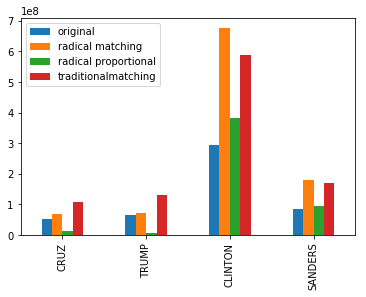

In [102]:
b[['original', 'radical matching', 'radical proportional', 'traditionalmatching']].plot(kind='bar')

In [74]:
b

,lr,pct,contributions,original,traditionalmatching
CRUZ,68216696,0.028550,1.419989e+07,54016803,108033606
TRUMP,70827744,0.011024,5.483195e+06,65344550,130689100
CLINTON,676842383,0.770538,3.832404e+08,293602014,587204028
SANDERS,178847323,0.189887,9.444361e+07,84403713,168807426
